In [1]:
%matplotlib inline

import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import math, csv
import sqlite3

In [28]:
# Mean median mode
# Graphs(boxplot barplot scatter plot etc

In [3]:

def store_data_in_db(csv_file):
    """
    store data from csv file to db
    """
    contents = []
    with open('alcocountry.csv') as file:
        csv_reader = csv.reader(file)
        for i, row in enumerate(csv_reader):
            contents.append(row)
    header = contents[0]  # column names
    try:
        con = sqlite3.connect('alcoholdata.db')
        print('-- connected to db --')
        curs = con.cursor()
        query = 'CREATE TABLE IF NOT EXISTS AlcoholTable (ID integer primary key AUTOINCREMENT NOT NULL, '

        #               # country 
        column_types = ['CHAR (30)', 'INTEGER', 'INTEGER', 'INTEGER', 'REAL']
        cols = zip(header, column_types)
        ncols = map(lambda x: ' '.join(x) + ', ', cols)
        final_str = (' '.join(ncols))[:-2]
        query += final_str + ');'
        curs.execute(query)
        print('-- AlcoholTable created --.')
        # print(query)
        column_names = ', '.join(header)
        query = f"INSERT OR REPLACE INTO AlcoholTable({column_names}) VALUES (?, ?, ?, ?, ?);"
        # insert data into the table
        for row in contents[1:]:
            # convert the data from str to the respective types
            row[0], row[1], row[2], row[3], row[4] = row[0], int(row[1]), int(row[2]), int(row[3]), float(row[4])
            curs.execute(query, (tuple(row)))
        con.commit()
        print('Data stored in db successfully')
        return header  # return the column names for future use
    except sqlite3.Error as e:
        print(e, type(e))
                


In [4]:
def load_data_from_db():
    """
    load data from the db
    """
    data = []
    with sqlite3.connect('alcoholdata.db') as con:
        curs = con.cursor()
        query = 'SELECT * FROM AlcoholTable'
        curs = con.cursor()
        curs.execute(query)
        if curs:
            for row in curs:
                data.append(row[1:])
    return data
                

In [5]:
def run_query(query):
    res = []
    with sqlite3.connect('alcoholdata.db') as con:
        curs = con.cursor()
        curs.execute(query)
        if curs:
            for result in curs:
                res.append(result)
    return res

In [6]:
csv_file_name = "alcocountry.csv"
columns = store_data_in_db(csv_file_name)  

-- connected to db --
-- AlcoholTable created --.
Data stored in db successfully


In [7]:
data = load_data_from_db()

In [8]:
#. Using the data
df = pd.DataFrame(data, columns=columns) # add the column names to the data retrieved
df.head(10)  # preview the data

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9
5,Antigua & Barbuda,102,128,45,4.9
6,Argentina,193,25,221,8.3
7,Armenia,21,179,11,3.8
8,Australia,261,72,212,10.4
9,Austria,279,75,191,9.7


In [9]:
# obtain useful statistics such as min, max, standard deviation, count, etc.
stats = df.describe()
cols = stats.columns
ranges = {}
sum_ = {}
for col in cols:
    ranges[col] = stats[col]['max'] - stats[col]['min']
    sum_[col] = sum(df[col])
stats = stats.append(pd.Series(ranges, name='range'), ignore_index=False)
stats = stats.append(pd.Series(sum_, name='sum'), ignore_index=False)
stats

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,386.000000,386.000000,386.000000,386.000000
mean,106.160622,80.994819,49.450777,4.717098
std,101.011662,88.169583,79.594028,3.768395
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4.000000,1.000000,1.300000
50%,76.000000,56.000000,8.000000,4.200000
75%,188.000000,128.000000,59.000000,7.200000
max,376.000000,438.000000,370.000000,14.400000
range,376.000000,438.000000,370.000000,14.400000
sum,40978.000000,31264.000000,19088.000000,1820.800000


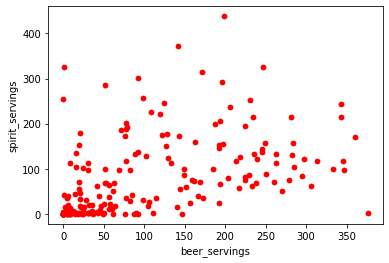

In [10]:
# visualizing the data
df.plot(kind='scatter',x='beer_servings',y='spirit_servings',color='red')
# the plot seems to show that there's no relationship between both columns (beer_servings and spirit_servings)

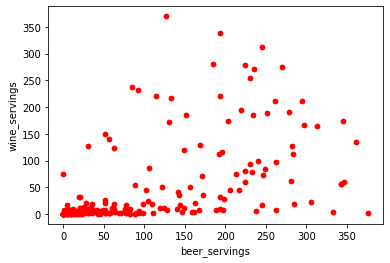

In [11]:
df.plot(kind='scatter',x='beer_servings',y='wine_servings',color='red')
# the plot seems to show that there's no relationship between both columns (beer_servings and wine_servings)

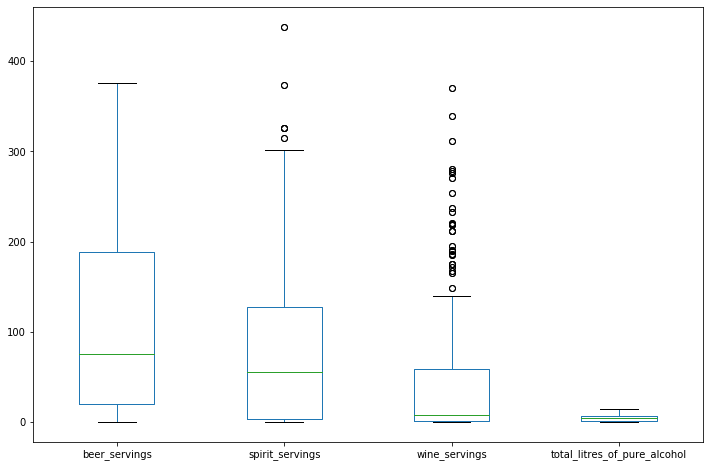

In [12]:
df.plot(kind='box', figsize=(12, 8))
# boxplot of our data, showing its distribution

In [13]:
# correlation between pairs
df.corr()
# we see that there exists some correlation/relationship between beer_servings and wine_servings, and a huge correlation
# between total litres of pure alcohol and beer_servings.
# this indicates that the total liters is influenced majorly by beer servings

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
beer_servings,1.000000,0.458819,0.527172,0.835839
spirit_servings,0.458819,1.000000,0.194797,0.654968
wine_servings,0.527172,0.194797,1.000000,0.667598
total_litres_of_pure_alcohol,0.835839,0.654968,0.667598,1.000000


In [14]:
# let us investigate whether there's a significant relationship between wine_servings and beer_servings
# we will utilize the principle of hypothesis testing to determine if there's a significant relationship between beer_servings
# and wine_servings

#set up the hypothesis
#  Ho: There is no relationship between wine servings and beer servings (null hypothesis)
#  H1: Ho is not true, that is, there exists a relationship  (alternate hypothesis)

In [15]:
# we shall utilize the scipy.stats library for this test
# import scipy
import scipy.stats

In [16]:
#  The statistical test to be used is a simple linear regression. 
#  This is because the simple linear regression is used to estimate the relationship between two quantitative variables.

In [17]:
a = df['beer_servings']
b = df['wine_servings']
result = scipy.stats.linregress(a, b)
slope, intercept, r_value, p_value, std_err = result
print("slope: %f    intercept: %f" % (slope, intercept))
print("p-value: %f    r-value: %e"% (p_value, r_value))
print("R-squared: %f" % r_value**2)

# This regression model accounts/explains for 27.8% (R-squared * 100) of the variance in the entire data
# we observe that the p-value is 0, thus, we reject the null hypothesis (H0), 
# this implies that there's actually a significant relationship between beer_servings and wine_servings

slope: 0.415395    intercept: 5.352208
p-value: 0.000000    r-value: 5.271717e-01
R-squared: 0.277910


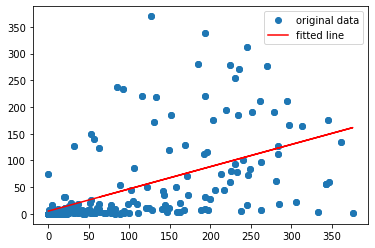

In [18]:
plt.plot(a, b, 'o', label='original data')
plt.plot(a, intercept + slope*a, 'r', label='fitted line')
plt.legend()
plt.show()

# so we know that the beer_servings and wine_servings are related for any given country,
# this implies that most people drinking beer would also drink wine, and vice versa.

In [19]:
# get the country with the highest beer servings using sql query
result = run_query('select beer_servings from AlcoholTable order by beer_servings DESC;')
highest = result[0][0]
lowest = result[-1][0]
print('highest', 
      run_query('select DISTINCT country from AlcoholTable where beer_servings ='+str(highest))
     )
print('lowest',
     run_query('select DISTINCT country from AlcoholTable where beer_servings ='+str(lowest))
     )

highest [('Namibia',)]
lowest [('Afghanistan',), ('Bangladesh',), ('Cook Islands',), ('North Korea',), ('Iran',), ('Kuwait',), ('Libya',), ('Maldives',), ('Marshall Islands',), ('Mauritania',), ('Monaco',), ('Pakistan',), ('San Marino',), ('Saudi Arabia',), ('Somalia',)]


In [20]:
# get the country with the highest total litres of pure alcohol using sql query

result = run_query('select total_litres_of_pure_alcohol from AlcoholTable order by total_litres_of_pure_alcohol DESC;')
highest = result[0][0]
lowest = result[-1][0]
print('highest', 
      run_query('select DISTINCT country from AlcoholTable where total_litres_of_pure_alcohol ='+str(highest))
     )
print('lowest',
     run_query('select DISTINCT country from AlcoholTable where total_litres_of_pure_alcohol ='+str(lowest))
     )

# Belarus has the highest alcohol consumption

highest [('Belarus',)]
lowest [('Afghanistan',), ('Bangladesh',), ('North Korea',), ('Iran',), ('Kuwait',), ('Libya',), ('Maldives',), ('Marshall Islands',), ('Mauritania',), ('Monaco',), ('Pakistan',), ('San Marino',), ('Somalia',)]


In [21]:
# get the country with the highest spirit servings using sql query

result = run_query('select spirit_servings from AlcoholTable order by spirit_servings DESC;')
highest = result[0][0]
lowest = result[-1][0]
print('highest', 
      run_query('select DISTINCT country from AlcoholTable where spirit_servings ='+str(highest))
     )
print('lowest',
     run_query('select DISTINCT country from AlcoholTable where spirit_servings ='+str(lowest))
     )

highest [('Grenada',)]
lowest [('Afghanistan',), ('Algeria',), ('Bangladesh',), ('Bhutan',), ('Burundi',), ('North Korea',), ('Equatorial Guinea',), ('Eritrea',), ('Gambia',), ('Guinea',), ('Iran',), ('Kuwait',), ('Laos',), ('Libya',), ('Maldives',), ('Marshall Islands',), ('Mauritania',), ('Monaco',), ('Nauru',), ('Pakistan',), ('San Marino',), ('Somalia',), ('Yemen',)]


In [22]:
# get the country with the highest wine servings using sql query

result = run_query('select wine_servings from AlcoholTable order by wine_servings DESC;')
highest = result[0][0]
lowest = result[-1][0]
print('highest', 
      run_query('select DISTINCT country from AlcoholTable where wine_servings ='+str(highest))
     )
print('lowest',
     run_query('select DISTINCT country from AlcoholTable where wine_servings ='+str(lowest))
     )


highest [('France',)]
lowest [('Afghanistan',), ('Bangladesh',), ('Bhutan',), ('Burundi',), ('North Korea',), ('Eritrea',), ('Ethiopia',), ('India',), ('Indonesia',), ('Iran',), ('Iraq',), ('Kuwait',), ('Lesotho',), ('Libya',), ('Malaysia',), ('Maldives',), ('Marshall Islands',), ('Mauritania',), ('Monaco',), ('Myanmar',), ('Nepal',), ('Pakistan',), ('Rwanda',), ('San Marino',), ('Saudi Arabia',), ('Somalia',), ('Sri Lanka',), ('Sudan',), ('Tajikistan',), ('Uganda',), ('Yemen',)]


In [23]:
# it turns out that Afghanistan has the lowest servings in beer, spirit and wine!
# France has the highest wine consumption, Grenada the highest spirit consumption and Belarus the highest beer consumption

In [24]:
# other extensional analysis: Ordinary Least Squares
from statsmodels.formula.api import ols

In [25]:
model = ols("total_litres_of_pure_alcohol ~ beer_servings + wine_servings + spirit_servings	", df).fit()

# Print the summary
model.summary()
# the model explains 87.2% of the variation in the data! (R-squared = 0.872)
# we also observe other properties

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     total_litres_of_pure_alcohol   R-squared:                       0.874
Model:                                      OLS   Adj. R-squared:                  0.873
Method:                           Least Squares   F-statistic:                     884.6
Date:                          Thu, 28 May 2020   Prob (F-statistic):          1.67e-171
Time:                                  21:02:07   Log-Likelihood:                -659.24
No. Observations:                           386   AIC:                             1326.
Df Residuals:                               382   BIC:                             1342.
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7224      0.105      6.883      0.000       0.516       0.929
beer_servings       0.0183      0.001     20.768      0.000       0.017       0.020
wine_servings       0.0160      0.001     15.797      0.000       0.014       0.018
spirit_servings     0.0156      0.001     17.787      0.000       0.014       0.017
==============================================================================
Omnibus:                      298.001   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3187.492
Skew:                           3.394   Prob(JB):                         0.00
Kurtosis:                      15.333   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# features of interests
model.params
# we see the corresponding coefficients for the columns used in the model

Intercept          0.722450
beer_servings      0.018303
wine_servings      0.016005
spirit_servings    0.015558
dtype: float64

In [27]:
# the standard errors of the model
print('Standard errors: ', model.bse)

Standard errors:  Intercept          0.104963
beer_servings      0.000881
wine_servings      0.001013
spirit_servings    0.000875
dtype: float64
